## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import random, time
from sklearn.model_selection import train_test_split
from nltk import pos_tag
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first fifteen data
print(nltk_data[:15])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# length of nltk data
print(len(nltk_data))

3914


### Build the vanilla Viterbi based POS tagger

train and validation split of data 

In [5]:
# set random.seed to number so that every time it generate same output for the project
random.seed(333)
train, validation = train_test_split(nltk_data,test_size=0.05,random_state=333)

In [6]:
print(train[:5])

[[('In', 'ADP'), ('August', 'NOUN'), (',', '.'), ('Temple', 'NOUN'), ('sweetened', 'VERB'), ('the', 'DET'), ('offer', 'NOUN'), ('to', 'PRT'), ('$', '.'), ('63', 'NUM'), ('*U*', 'X'), ('a', 'DET'), ('share', 'NOUN'), (',', '.'), ('or', 'CONJ'), ('$', '.'), ('963', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('.', '.')], [('May', 'NOUN'), ('Stores', 'NOUN'), (',', '.'), ('St.', 'NOUN'), ('Louis', 'NOUN'), (',', '.'), ('runs', 'VERB'), ('such', 'ADJ'), ('well-known', 'ADJ'), ('department', 'NOUN'), ('stores', 'NOUN'), ('as', 'ADP'), ('Lord', 'NOUN'), ('&', 'CONJ'), ('Taylor', 'NOUN'), ('.', '.')], [('The', 'DET'), ('Soviet', 'ADJ'), ('purchases', 'NOUN'), ('are', 'VERB'), ('so', 'ADV'), ('massive', 'ADJ'), ('that', 'ADP'), ('exporters', 'NOUN'), ('are', 'VERB'), ('struggling', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('find', 'VERB'), ('enough', 'ADJ'), ('river', 'NOUN'), ('barges', 'NOUN'), ('and', 'CONJ'), ('trains', 'NOUN'), ('0', 'X'), ('*T*-2', 'X'), ('to', 'PRT'), ('move', 'VERB'), ('the

In [7]:
print(validation[:5])

[[('Mr.', 'NOUN'), ('McGuigan', 'NOUN'), ('cites', 'VERB'), ('three', 'NUM'), ('completed', 'VERB'), ('efforts', 'NOUN'), ('in', 'ADP'), ('Oklahoma', 'NOUN'), ('.', '.')], [('According', 'VERB'), ('to', 'PRT'), ('reports', 'NOUN'), ('carried', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('various', 'ADJ'), ('news', 'NOUN'), ('services', 'NOUN'), (',', '.'), ('the', 'DET'), ('Brazilian', 'ADJ'), ('government', 'NOUN'), ('told', 'VERB'), ('its', 'PRON'), ('sugar', 'NOUN'), ('producers', 'NOUN'), ('that', 'ADP'), ('they', 'PRON'), ('wo', 'VERB'), ("n't", 'ADV'), ('be', 'VERB'), ('allowed', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('export', 'VERB'), ('sugar', 'NOUN'), ('during', 'ADP'), ('the', 'DET'), ('current', 'ADJ'), ('1989-90', 'NUM'), ('season', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-92', 'X'), ('began', 'VERB'), ('May', 'NOUN'), ('1', 'NUM'), (',', '.'), ('and', 'CONJ'), ('the', 'DET'), ('1990-91', 'NUM'), ('season', 'NOUN'), ('so', 'ADP'), ('that', 'ADP'), ('it', 'PRON'), ('can', 'VER

#### Extract tokens and tags from train set

In [8]:
# get list of tagged words in from of tuples
train_tuples = [tup for sentance in train for tup in sentance]
print(len(train_tuples))
print(train_tuples[:5])

95460
[('In', 'ADP'), ('August', 'NOUN'), (',', '.'), ('Temple', 'NOUN'), ('sweetened', 'VERB')]


In [9]:
# Extract tokens from the tuples
tokens = [token[0] for token in train_tuples]
print(tokens[:5])

['In', 'August', ',', 'Temple', 'sweetened']


In [10]:
# total number of words 
print('Number of total words ',len(tokens))

Number of total words  95460


In [11]:
# total number of unique words 
print('Number of unique words ',len(set(tokens)))

Number of unique words  12040


In [12]:
# Extract tags from the  tuples
tags = [tags[1] for tags in train_tuples]
print(tags[:5])

['ADP', 'NOUN', '.', 'NOUN', 'VERB']


In [13]:
# total number of tags
print('Total Number of tags: ',len(tags))

Total Number of tags:  95460


In [14]:
# total number of unique tags
print('Total Number of tags: ',len(set(tags)))

Total Number of tags:  12


In [15]:
# read the file for testing data
# test_file = open("Test_sentences.txt").read()
# test_file

test_file = "Android is a mobile operating system developed by Google.\nAndroid has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\nGoogle and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\nTwitter is an online news and social networking service on which users post and interact with messages known as tweets.\nBefore entering politics, Donald Trump was a domineering businessman and a television personality.\nThe 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\nThis is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\nShow me the cheapest round trips from Dallas to Atlanta\nI would like to see flights from Denver to Philadelphia.\nShow me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\nNASA invited social media users to experience the launch of ICESAT-2 Satellite.\n\n\n\n"
test_file

"Android is a mobile operating system developed by Google.\nAndroid has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\nGoogle and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\nTwitter is an online news and social networking service on which users post and interact with messages known as tweets.\nBefore entering politics, Donald Trump was a domineering businessman and a television personality.\nThe 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\nThis is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\nShow me the cheapest round trips from Dallas to Atlanta\nI would like to see flights from Denver to Philadelphia.\nShow me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\nNASA invited social media users to experience the launch of ICESAT-2 Satell

In [16]:
# tokenise the sample test file into words
test_tokens = word_tokenize(test_file)
test_tokens[:10]

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.']

#### Caluculate the Emission Probability and transition probability 

In [17]:
'''
    Emission Probability is given as the probability of a given word emitted by a tag;
    P(t2/t1): tag2(t2) given tag1 (t1), i.e. Transition Probability 
'''
tokens_unique = set(tokens)
tags_unique = set(tags)
t = len(tags_unique)
v = len(tokens_unique)

In [18]:
# let's create a zero matrix of unique tokens and tags
matrix = np.zeros((t,v))
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
# Emission Probability function 
def word_given_tag(word, tag, train_bag = train_tuples):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

# Transition Probability Function

def t2_given_t1(t2, t1, train_bag = train_tuples):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [20]:
#  create a t X t matrix of tags each column is t2 , each row is t1 
transition_matrix = np.zeros((t,t),dtype='float32')
for i, t1 in enumerate(list(tags_unique)):
    for j, t2 in enumerate(list(tags_unique)):
        transition_matrix[i,j] = t2_given_t1(t2,t1)[0]/t2_given_t1(t2,t1)[1]
transition_matrix

array([[6.63687512e-02, 1.22476006e-02, 7.00761318e-01, 2.10195296e-02,
        6.47136718e-02, 2.05230061e-02, 4.63422714e-03, 7.67957643e-02,
        4.46871901e-03, 1.72128435e-02, 1.05925193e-02, 6.62032457e-04],
       [6.52359873e-02, 1.69115931e-01, 1.10022552e-01, 2.24710368e-02,
        3.53005193e-02, 2.18723267e-01, 1.35214984e-01, 9.12059695e-02,
        8.11756477e-02, 5.28730266e-03, 3.05575002e-02, 3.56892943e-02],
       [1.19208684e-02, 1.47036240e-01, 2.63758361e-01, 9.47087444e-03,
        2.38344237e-01, 2.89245620e-02, 1.32738510e-02, 1.78154826e-01,
        1.74059309e-02, 4.28200550e-02, 4.42096032e-02, 4.68058651e-03],
       [3.28888893e-02, 1.80740748e-02, 3.54962975e-01, 1.88148141e-01,
        1.17333330e-01, 2.08592594e-01, 2.37037032e-03, 3.40740755e-02,
        2.66666664e-03, 1.33333337e-02, 2.63703708e-02, 1.18518516e-03],
       [4.41588983e-02, 8.84082913e-02, 2.19889596e-01, 8.10786337e-02,
        9.11229774e-02, 2.77802907e-02, 1.75006792e-01, 9.27

In [21]:
transition_df = pd.DataFrame(transition_matrix,columns= list(tags_unique), index= list(tags_unique))
transition_df

,ADJ,VERB,NOUN,NUM,.,X,DET,ADP,ADV,CONJ,PRT,PRON
ADJ,0.066369,0.012248,0.700761,0.021020,0.064714,0.020523,0.004634,0.076796,0.004469,0.017213,0.010593,0.000662
VERB,0.065236,0.169116,0.110023,0.022471,0.035301,0.218723,0.135215,0.091206,0.081176,0.005287,0.030558,0.035689
NOUN,0.011921,0.147036,0.263758,0.009471,0.238344,0.028925,0.013274,0.178155,0.017406,0.042820,0.044210,0.004681
NUM,0.032889,0.018074,0.354963,0.188148,0.117333,0.208593,0.002370,0.034074,0.002667,0.013333,0.026370,0.001185
.,0.044159,0.088408,0.219890,0.081079,0.091123,0.027780,0.175007,0.092752,0.051851,0.059090,0.002443,0.066329
X,0.017365,0.204397,0.060857,0.002868,0.164091,0.074558,0.054485,0.144655,0.026127,0.009877,0.185120,0.055600
DET,0.203178,0.039239,0.640828,0.022027,0.017573,0.045137,0.005537,0.009389,0.012759,0.000481,0.000120,0.003731
ADP,0.105959,0.007995,0.321288,0.062360,0.040401,0.034964,0.324912,0.016843,0.013751,0.000959,0.001492,0.069076
ADV,0.127369,0.343864,0.031260,0.032591,0.136681,0.023944,0.069504,0.116395,0.080811,0.007316,0.014965,0.015298
CONJ,0.114047,0.159017,0.349560,0.042652,0.036161,0.008345,0.119611,0.052388,0.054242,0.000464,0.005100,0.058414


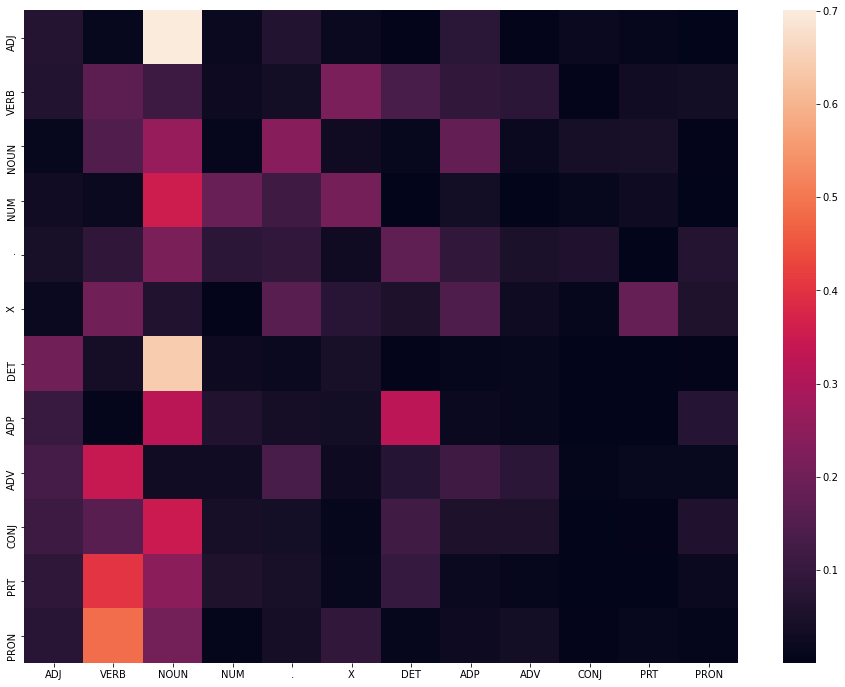

In [22]:
plt.figure(figsize=(16,12))
sns.heatmap(transition_df)
plt.show()

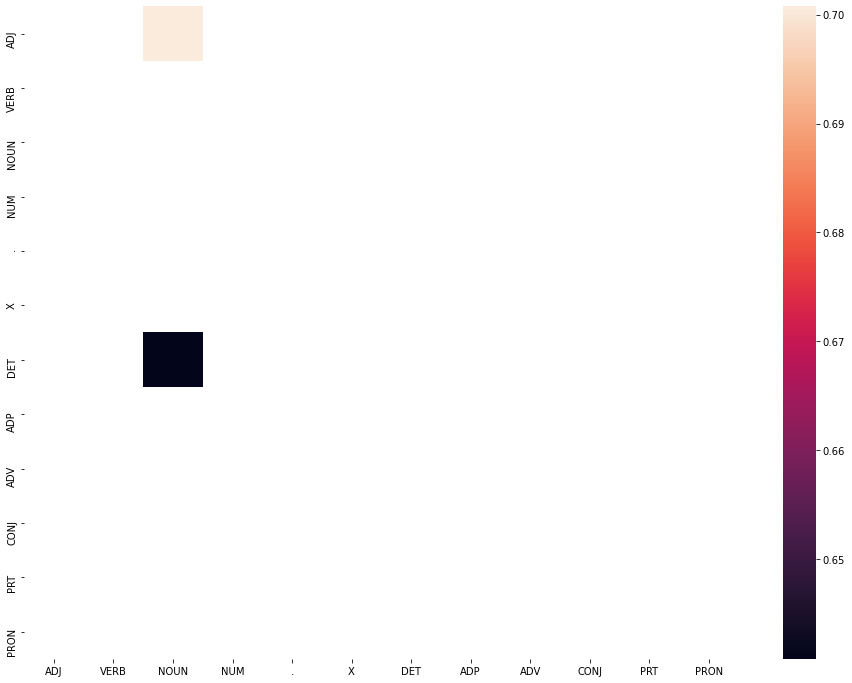

In [23]:
frequent_tags = transition_df[transition_df > 0.5]
plt.figure(figsize=(16,12))
sns.heatmap(frequent_tags)
plt.show()

#### From above heatmap we observe 
- The transition probability of NOUN follows ADj is 0.700761
- The transition probability of NOUN follows DET is 0.640828

### Now Implement the viterbi Algorithm 

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [24]:
len(train_tuples)

95460

In [25]:
# Viterbi Heuristic Algorithm
def Viterbi(words, train_bag = train_tuples):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = transition_df.loc['.', tag]
            else:
                transition_p = transition_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        print(key)
    return list(zip(words, state))


#### Evaluating the accuracy of tagging on Validation set

In [26]:
validation_tuples = [tup for sent in validation for tup in sent]
validation_words = [tuple[0] for tuple in validation_tuples]
validation_words[:10]

['Mr.',
 'McGuigan',
 'cites',
 'three',
 'completed',
 'efforts',
 'in',
 'Oklahoma',
 '.',
 'According']

In [27]:
# Apply viterbi algorithm
start = time.time()
validation_result = Viterbi(validation_words)
end = time.time()
difference = end-start

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215


In [28]:
print("Time take to run Viterbi: ",difference)

Time take to run Viterbi:  825.6068909168243


In [29]:
# now check Accuracy 
result = [i for i,j in zip(validation_tuples,validation_result) if i ==j]
accuracy = len(result)/len(validation_tuples)
print(accuracy)

0.9129601226993865


In [30]:
# incorrect tags 
validation_incorrect = [[validation_tuples[i-1],j] for i, j in enumerate(zip(validation_tuples,validation_result)) if j[0]!=j[1]]
validation_incorrect

[[('to', 'PRT'), (('export', 'VERB'), ('export', 'NOUN'))],
 [('the', 'DET'), (('1990-91', 'NUM'), ('1990-91', 'ADJ'))],
 [('season', 'NOUN'), (('so', 'ADP'), ('so', 'ADV'))],
 [('for', 'ADP'), (('automobile', 'NOUN'), ('automobile', 'ADJ'))],
 [('.', '.'), (('Marubeni', 'NOUN'), ('Marubeni', 'ADJ'))],
 [('Marubeni', 'NOUN'), (('advanced', 'VERB'), ('advanced', 'ADJ'))],
 [('to', 'PRT'), (('890', 'NUM'), ('890', 'ADJ'))],
 [('the', 'DET'), (('Hoosier', 'NOUN'), ('Hoosier', 'ADJ'))],
 [('its', 'PRON'), (('fall', 'NOUN'), ('fall', 'VERB'))],
 [('to', 'PRT'), (('as', 'ADV'), ('as', 'ADP'))],
 [('and', 'CONJ'), (('warehousing', 'NOUN'), ('warehousing', 'ADJ'))],
 [('on', 'ADP'), (('353', 'NUM'), ('353', 'ADJ'))],
 [('shares', 'NOUN'), (('*T*-121', 'X'), ('*T*-121', 'ADJ'))],
 [('*T*-121', 'X'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [("'s", 'PRT'), (('quarterly', 'ADV'), ('quarterly', 'ADJ'))],
 [("''", '.'), (('Shipments', 'NOUN'), ('Shipments', 'ADJ'))],
 [('relatively', 'ADV'), (('le

### Solve the problem of unknown words

#### Technique 1 : Use only Transition Probabilities for tagging unknown words

In [31]:
# viterbi algorithm with Transition Probabilities for tagging unknown words
def Viterbi_trans(words, train_bag = train_tuples):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] 
        for tag in T:
            if key == 0:
                transition_p = transition_df.loc['.', tag] 
            else:
                transition_p = transition_df.loc[state[-1], tag]
                
             # compute emission, transition and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p 
            p.append(state_probability)
            p_transition.append(transition_p)
        pmax = max(p)
        state_max = T[p.index(pmax)] 
         # getting state for which probability is maximum on the basis of transition Probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
        else: 
            state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

In [32]:
# tagging the validation sentences
start = time.time()
validation_trans_result = Viterbi_trans(validation_words)
end = time.time()
difference1 = end-start

In [33]:
# Time taken by algorithm
print("Time taken on validation set: ",difference1)

Time taken on validation set:  798.694607257843


In [34]:
# now check Accuracy 
result = [i for i,j in zip(validation_tuples,validation_trans_result) if i ==j]
accuracy = len(result)/len(validation_tuples)
print(accuracy)

0.9380751533742331


In [35]:
# incorrect tags 
validation_incorrect = [[validation_tuples[i-1],j] for i, j in enumerate(zip(validation_tuples,validation_result)) if j[0]!=j[1]]
validation_incorrect

[[('to', 'PRT'), (('export', 'VERB'), ('export', 'NOUN'))],
 [('the', 'DET'), (('1990-91', 'NUM'), ('1990-91', 'ADJ'))],
 [('season', 'NOUN'), (('so', 'ADP'), ('so', 'ADV'))],
 [('for', 'ADP'), (('automobile', 'NOUN'), ('automobile', 'ADJ'))],
 [('.', '.'), (('Marubeni', 'NOUN'), ('Marubeni', 'ADJ'))],
 [('Marubeni', 'NOUN'), (('advanced', 'VERB'), ('advanced', 'ADJ'))],
 [('to', 'PRT'), (('890', 'NUM'), ('890', 'ADJ'))],
 [('the', 'DET'), (('Hoosier', 'NOUN'), ('Hoosier', 'ADJ'))],
 [('its', 'PRON'), (('fall', 'NOUN'), ('fall', 'VERB'))],
 [('to', 'PRT'), (('as', 'ADV'), ('as', 'ADP'))],
 [('and', 'CONJ'), (('warehousing', 'NOUN'), ('warehousing', 'ADJ'))],
 [('on', 'ADP'), (('353', 'NUM'), ('353', 'ADJ'))],
 [('shares', 'NOUN'), (('*T*-121', 'X'), ('*T*-121', 'ADJ'))],
 [('*T*-121', 'X'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [("'s", 'PRT'), (('quarterly', 'ADV'), ('quarterly', 'ADJ'))],
 [("''", '.'), (('Shipments', 'NOUN'), ('Shipments', 'ADJ'))],
 [('relatively', 'ADV'), (('le

#### Technique 2 : Use Rule-Based(Regular Expression) Tagger to tag unknown words

In [36]:
# These are some of the words regex which is not correctly tagged in Validation dataset
regex_rules = [
    (r'.*ing$', 'VERB'),                          
    (r'.*ed$', 'VERB'),                           
    (r'.*es$', 'VERB'),                      
    (r'.*ould$', 'VERB'),                        
    (r'.[0-9]+\'?s$', 'NUM'),                    
    (r'.*\'s$', 'NOUN'),                          
    (r'.*s$', 'NOUN'),                            
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),            
    (r'^-?[0-9]+(.[0-9]+)?(th|st|nd)$', 'ADJ'),  
    (r'.*', 'NOUN')                            
]

In [37]:
# Viterbi Modification - Technique II By Regular Expression 
rule_based_tagger = nltk.RegexpTagger(regex_rules)
def Viterbi_rule(words, train_bag = train_tuples):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        sum_emission_p = 0
        tp = []
        for tag in T:
            if key == 0:
                transition_p = transition_df.loc['.', tag]
            else:
                transition_p = transition_df.loc[state[-1], tag]
             # compute emission, transition and state probabilities
            tp.append(transition_p)
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            sum_emission_p += emission_p
        # getting state for which probability is maximum on the basis of regular expression
        if sum_emission_p == 0:
            regex_tag = rule_based_tagger.tag(nltk.word_tokenize(word))
            state_max = regex_tag[0][1]
        else: 
            pmax = max(p)
            state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

In [38]:
# tagging the validation sentences
start = time.time()
validation_trans_result = Viterbi_rule(validation_words)
end = time.time()
difference2 = end-start

In [39]:
# Time taken to execute
print("Time taken on validation set: ",difference2)

Time taken on validation set:  799.6371796131134


In [40]:
# now check Accuracy 
result = [i for i,j in zip(validation_tuples,validation_trans_result) if i ==j]
accuracy = len(result)/len(validation_tuples)
print(accuracy)

0.9511119631901841


In [41]:
# incorrect tags 
validation_incorrect = [[validation_tuples[i-1],j] for i, j in enumerate(zip(validation_tuples,validation_result)) if j[0]!=j[1]]
validation_incorrect

[[('to', 'PRT'), (('export', 'VERB'), ('export', 'NOUN'))],
 [('the', 'DET'), (('1990-91', 'NUM'), ('1990-91', 'ADJ'))],
 [('season', 'NOUN'), (('so', 'ADP'), ('so', 'ADV'))],
 [('for', 'ADP'), (('automobile', 'NOUN'), ('automobile', 'ADJ'))],
 [('.', '.'), (('Marubeni', 'NOUN'), ('Marubeni', 'ADJ'))],
 [('Marubeni', 'NOUN'), (('advanced', 'VERB'), ('advanced', 'ADJ'))],
 [('to', 'PRT'), (('890', 'NUM'), ('890', 'ADJ'))],
 [('the', 'DET'), (('Hoosier', 'NOUN'), ('Hoosier', 'ADJ'))],
 [('its', 'PRON'), (('fall', 'NOUN'), ('fall', 'VERB'))],
 [('to', 'PRT'), (('as', 'ADV'), ('as', 'ADP'))],
 [('and', 'CONJ'), (('warehousing', 'NOUN'), ('warehousing', 'ADJ'))],
 [('on', 'ADP'), (('353', 'NUM'), ('353', 'ADJ'))],
 [('shares', 'NOUN'), (('*T*-121', 'X'), ('*T*-121', 'ADJ'))],
 [('*T*-121', 'X'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [("'s", 'PRT'), (('quarterly', 'ADV'), ('quarterly', 'ADJ'))],
 [("''", '.'), (('Shipments', 'NOUN'), ('Shipments', 'ADJ'))],
 [('relatively', 'ADV'), (('le

#### Evaluating tagging accuracy

##### Tagging accuracy on validation set
* Time Taken and accuracy of Viterbi POS tagger
    - Time Taken :- 825.6068909168243
    - Accuracy :- 91.30
* Time Taken and accuracy of Viterbi Modified with transition probability POS tagger
    - Time Taken :- 798.694607257843
    - Accuracy :- 93.81
* Time Taken and accuracy of Viterbi Modified with rule based POS tagger
    - Time Taken :- 799.6371796131134
    - Accuracy :- 95.11

##### Tagging accuracy on test set

In [42]:
# Apply viterbi algorithm
start = time.time()
test_result = Viterbi(test_tokens)
end = time.time()
difference = end-start
print("Time taken on validation set: ",difference)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
Time taken on validation set:  28.569313049316406


In [43]:
test_result

[('Android', 'ADJ'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'ADJ'),
 ('.', '.'),
 ('Android', 'ADJ'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'ADJ'),
 ('worldwide', 'ADJ'),
 ('on', 'ADP'),
 ('smartphones', 'ADJ'),
 ('since', 'ADP'),
 ('2011', 'ADJ'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'ADJ'),
 ('.', '.'),
 ('Google', 'ADJ'),
 ('and', 'CONJ'),
 ('Twitter', 'ADJ'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'ADJ'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'ADJ'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'ADJ'),
 ("'s", 'PRT'),
 ('firehose', 'ADJ'),
 ('.', '.'),
 ('Twitter', 'ADJ'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADJ'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOU

#### Observation
- There are total 28 unique words which appears 36 times in the sentences. These words are:- Android, Google, OS, worldwide, smartphones, 2011, 2013, Twitter, 2015, firehose, online, interact, messages, tweets, domineering, personality, 2018, FIFA, Cup, 21st, tournament, contested, trips, arriving, NASA, invited, ICESAT-2, Satellite
- All the unknown words assigned the first tag in the training set i.e. '.'

In [44]:
start = time.time()
test_trans_result = Viterbi_trans(test_tokens)
end = time.time()
difference = end-start
print("Time taken on validation set: ",difference1)

Time taken on validation set:  798.694607257843


In [45]:
test_trans_result

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'DET'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'DET'),
 ('since', 'ADP'),
 ('2011', 'DET'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'DET'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'DET'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'X'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'VERB'),
 ("'s", 'PRT'),
 ('firehose', 'VERB'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('servic

#### Observation
- 'Android' and Organization abbreviations like NASA, FIFA has been properly tagged as NOUN in all cases.
- 'ICESAT-2' is assigned as DET which is incorrect.
- 'Google' has been tagged correctly as 'NOUN' but incorrectly as 'X','DET' once.
- 'Twitter' has also been tagged correctly as NOUN but incorrectly as VERB 
- Years like 2011, 2013 and 2018 have been incorrectly tagged as DET and Noun
- ordinal numerals like the word '21st'has been assigned the tag of NOUN which is wrong
- The word 'arriving' has been incorrectly tagged as NOUN

In [46]:
start = time.time()
test_rule_result = Viterbi_rule(test_tokens)
end = time.time()
difference = end-start
print("Time taken on validation set: ",difference1)

Time taken on validation set:  798.694607257843


In [47]:
test_rule_result

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('s

#### Observation
- Years like 2011, 2013, 2015, 2018 is correctly tagged as NUM.
- Ordinal numerals like the word '21st' is correctly assigned the tag of ADJ.
- The word 'arriving' is correctly tagged as VERB.


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

#### Vanilla Viterbi : 
* Accuracy : 0
* All 36 occurances of unknown words and all are tagged incorrectly.

#### Viterbi with Transition Probability
* Accuracy : ~59%(21/36)
* The following 15 words are not properly tagged: 
     ('Google', 'DET'),
     ('Google', 'X'),
     ('2011', 'DET'),
     ('2013', 'DET'),
     ('2015', 'DET'),
     ('2018', 'NOUN'),
     ('Twitter', 'VERB'),
     ('firehose', 'VERB'),
     ('online', 'NOUN'),
     ('tweets', 'DET'),
     ('domineering', 'NOUN'),
     ('21st', 'NOUN'),
     ('contested', 'NOUN'),
     ('arriving', 'NOUN'),
     ('invited', 'NOUN')
     
#### Viterbi algorithm with Rule based tagger
* accuracy: 89% (32/36)
* The following 4 is not correctly tagged:
     ('smartphones', 'VERB') 
     ('online', 'NOUN')      
     ('messages', 'VERB')    
     ('domineering', 'VERB') 


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications


### Viterbi
    The Viterbi Algorithm without modification is unable to find all unknown words and assign it with the first tag 


### Viterbi after applying two techniques
    - 'Android','Google','Twitter','ICESAT-2' and Organization abbreviations like NASA, FIFA has been correctly tagged as NOUN in all cases. 
    - Years like 2011, 2013, 2015, 2018 is correctly tagged as NUM.
    - Adjectival ordinal numerals like the word '21st' is correctly assigned the tag of ADJ.
    - The word 'arriving' is correctly tagged as VERB.